### Image Classification on the MNIST Dataset

In this chapter, I learn image classification Machine Learning algorithms, and how they work. Before anything, prepare the workspace.

In [2]:
import os
import shutil
from sklearn.datasets import fetch_openml

MB = 1024 * 1024
DATA_HOME = "../datasets"
NEW_DATASET_EVERYTIME = False

print("New dataset everytime:", NEW_DATASET_EVERYTIME)

if NEW_DATASET_EVERYTIME and os.path.exists(DATA_HOME):
    shutil.rmtree(DATA_HOME)
    print("Dataset directory removed")

    os.makedirs(DATA_HOME)
    print("Now downloading dataset")

if not NEW_DATASET_EVERYTIME:
    print("Reusing existing dataset")

MNIST = fetch_openml("mnist_784", as_frame=False, data_home=DATA_HOME)

data_size = MNIST.data.nbytes / MB
target_size = MNIST.target.nbytes / MB
total = data_size + target_size

print(f"\n{'Dataset size:':12} {data_size:4.2f} MB")
print(f"{'Target size:':12} {target_size:4.2f} MB")
print(f"{'Total size:':12} {total:4.2f} MB\n")

print("Done")

New dataset everytime: False
Reusing existing dataset

Dataset size: 418.70 MB
Target size: 0.53 MB
Total size:  419.24 MB

Done


### Exploration Phase

I'm looking at potentially useful information about the features (X) and labels (y), in general what's known as 'exploratory data analysis'.

In [3]:
features, labels = MNIST.data, MNIST.target

print("Features (X):", features)
print("Labels (y):", labels)

print("\nShape (X):", features.shape)
print("Shape (y):", labels.shape)

print("\nFeatures data (row 1):\n", features[0, : ])
print("\nRow 1 size:", features[0].size)

Features (X): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Labels (y): ['5' '0' '4' ... '4' '5' '6']

Shape (X): (70000, 784)
Shape (y): (70000,)

Features data (row 1):
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253

The dataset has 70,000 images each with 784 features.

#### Plotting images

Since the images are supposed to be 28x28 pixels, and the 784 pixels represent the color intensity of the images at each pixel, we can
print the digits using Matplotlib. All we need to do is reshape the data into a 28x28 matrix and color the points appropriately.

Label at this index: 4


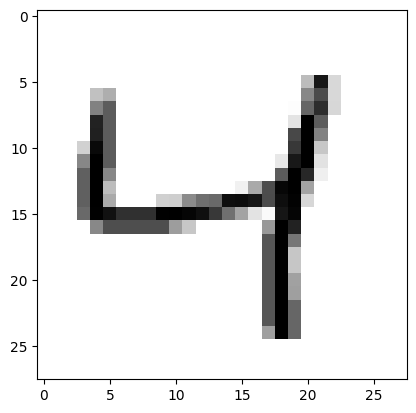

In [4]:
from matplotlib import pyplot as plt
import numpy as np

def plot_image(image_data):
    image = np.reshape(image_data, (28, 28))
    plt.imshow(image, cmap="binary")
    # plt.axis("off")

index = 2
first_image_data = features[index]
print("Label at this index:", labels[index])
plot_image(first_image_data)

### Split Test and Train Datasets

I will use the first 60,000 images for training and the remaining 10,000 for testing and evaluating the model's final performance.

In [5]:
SPLIT = 60_000

X_train, X_test = features[:SPLIT], features[SPLIT:]
y_train, y_test = labels[:SPLIT], labels[SPLIT:]

print("Features (train) size:", X_train.shape[0])
print("Features (test) size:", X_test.shape[0])

print("\nLabels (train) size:", y_train.shape[0])
print("Labels (test) size:", y_test.shape[0])

Features (train) size: 60000
Features (test) size: 10000

Labels (train) size: 60000
Labels (test) size: 10000


### Training a Binary Classifier

First of all we'll work on a binary classifier for the number 5. We'll split the labels (both at the test and train).


In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

y_train_5

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In the book, they use a Stochastic Gradient Descent (SGD) classifier.

In [7]:
from sklearn.linear_model import SGDClassifier

RANDOM_STATE = 42

SGD_clf = SGDClassifier(random_state=RANDOM_STATE)
SGD_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [8]:
# Training is complete, note, first_image_data points to 4 presently
# the model should accurately predict false
SGD_clf.predict([X_train[0], first_image_data])

array([ True, False])

### Evaluating Our Model's Performance

First off, our trusty K-Fold Cross Validation.

In [9]:
from sklearn.model_selection import cross_val_score

# Model evaluation configuration parameters
K_FOLDS = 3
SCORING_CRITERIA = "accuracy"

cross_val_score(SGD_clf, X_train, y_train_5, cv=K_FOLDS, scoring=SCORING_CRITERIA)

array([0.95035, 0.96035, 0.9604 ])

Impressive scores from the above across 3 folds. But alas, we've been deceived. It only ranks so high because the model has learned to guess "Not 5", since 5's make up only 10% of the dataset.

A much better way to measure the performance of a Classifier is to use what's called a Confusion Matrix.

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_5_pred = cross_val_predict(SGD_clf, X_train, y_train_5, cv=K_FOLDS)
print("Labels predicted for number 5 (cross prediction):", y_train_5_pred)

Labels predicted for number 5 (cross prediction): [ True False False ...  True False False]


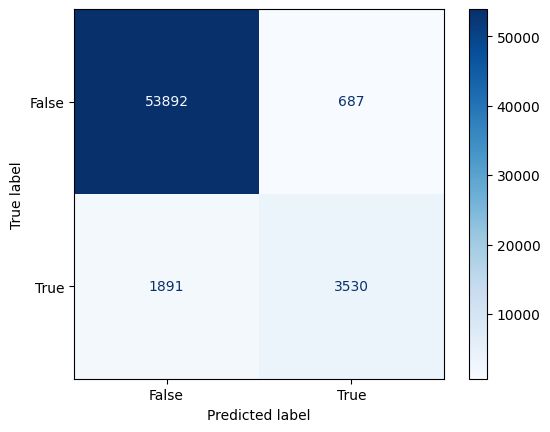

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CMAP = "Blues"

cm = confusion_matrix(y_train_5, y_train_5_pred, labels=SGD_clf.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SGD_clf.classes_)
cm_disp.plot(cmap=CMAP)

plt.show()

From the Confusion Matrix above, we can see:

1. 53,892 true negatives.
   
2. 687 false positives (Type I error).

3. 1891 false negatives (Type II error).

4. 3530 true positives.

In [12]:
# Precision: TP / TP + FP
# Recall: TP / TP + FN

true_positives = cm[-1, -1]
false_positives = cm[0, -1]
false_negatives = cm[-1, 0]

precision = true_positives / (false_positives + true_positives)
recall = true_positives / (false_negatives + true_positives)

print("Model Precision:", precision)
print("Model Recall:", recall)

Model Precision: 0.8370879772350012
Model Recall: 0.6511713705958311


Of course, SciKit Learn already has this covered.

In [13]:
from sklearn.metrics import precision_score, recall_score

model_precision_score = precision_score(y_train_5, y_train_5_pred)
model_recall_score = recall_score(y_train_5, y_train_5_pred)

print("Model Precision score:", model_precision_score)
print("Model Recall score:", model_recall_score)

Model Precision score: 0.8370879772350012
Model Recall score: 0.6511713705958311


#### F1 Score

$$2 \times \frac{Precision \times Recall}{Precision + Recall}$$

In [14]:
from sklearn.metrics import f1_score

model_F1_score = f1_score(y_train_5, y_train_5_pred)
print("Model F1 score:", model_F1_score)

Model F1 score: 0.7325171197343847


#### Determining Thresholds

In [15]:
VALIDATION_METHOD = "decision_function"
y_scores = cross_val_predict(SGD_clf, X_train, y_train_5, cv=K_FOLDS, method=VALIDATION_METHOD)

#### Precision Recall Curves

thresholds: [-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]


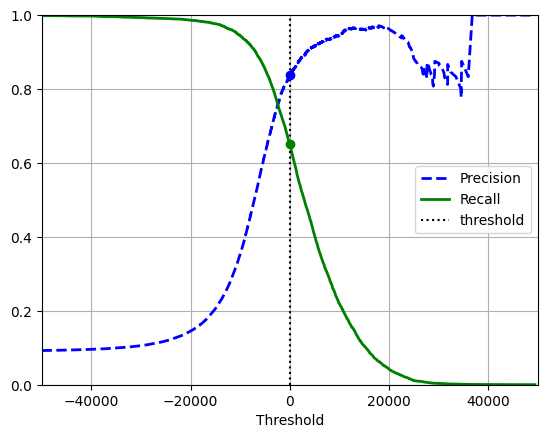

In [16]:
from sklearn.metrics import precision_recall_curve

# y_scores are the label scores
threshold = 0
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print("thresholds:", thresholds)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

### The ROC Curve (Receiver Operating Characteristic)

This is another metric used to evaluate the performance of Binary Classifiers. It measures the True Positive Rate (Recall / TPR) against the False Positive Rate (FPR).

$$FPR = 1 - TPR$$

The False Positive Rate is also called the "Fall Out", while the True Positive Rate (TPR) is called "Specificity".

Recall = Specificity = True Positive Rate (in a nutshell)

In [17]:
print("thresholds:", thresholds)

idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

thresholds: [-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]


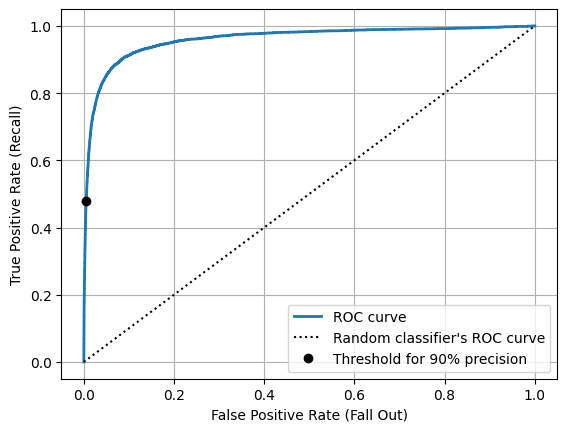

In [18]:
from sklearn.metrics import roc_curve

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# argmax() returns the first index where the condition is true
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend(loc = "lower right")
plt.xlabel("False Positive Rate (Fall Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid(True)
plt.show()

### RandomForest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)

y_probabilities_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=K_FOLDS, method="predict_proba")

# It returns an array of tuples each with the negative and positive likelihoods
y_probabilities_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [27]:
y_scores_forest = y_probabilities_forest[:, 1]
recalls_forest, precisions_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

print("Random Forest Classifier:")
print("Recall (first 5):", recalls_forest[:5])
print("Precision (first 5):", precisions_forest[:5])

Random Forest Classifier:
Recall (first 5): [0.09035    0.15601796 0.21697018 0.2782198  0.3359375 ]
Precision (first 5): [1.         1.         1.         0.99981553 0.9994466 ]


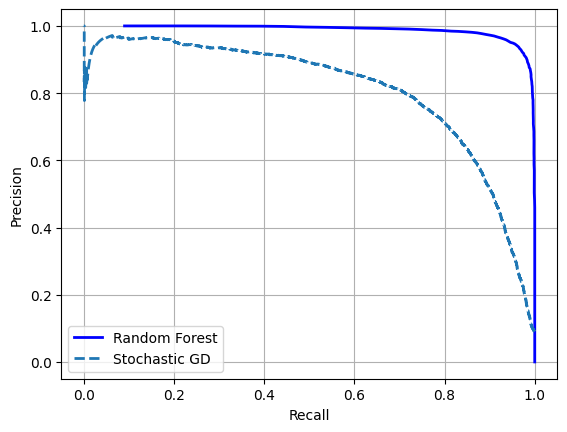

In [33]:
plt.plot(recalls_forest, precisions_forest ,"b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="Stochastic GD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.locator_params(axis='both', nbins=7)
plt.grid(True)
plt.show()

We can see from the plot that the Random Forest classifier performs much better than the SGD classifier. It's ROC curve is much closer to the top right than the other.

In [39]:
from sklearn.metrics import roc_auc_score

y_pred_forest = (y_probabilities_forest >= 0.5)[:,1]

f1_score_forest = f1_score(y_train_5, y_pred_forest)
roc_auc_score_forest = roc_auc_score(y_train_5, y_pred_forest)

print("F1 score:", f1_score_forest)
print("ROC AUC score:", roc_auc_score_forest)

F1 score: 0.9274509803921569
ROC AUC score: 0.9358174809192218


### Multi-class Classification

There are two common srategies for multi-class classification:

- One versus the Rest (OvR): This strategy trains a unique classifier for each label, and then when you want to classify data, you select the model with the highest decision score. You can think of it as having N binary classifiers, each attuned to the specific class.

- One verses One (OvO): This strategy requires $\frac{N(N-1)}{2}$ unique classifiers, each class is pitted against every other class. You train classifiers to vote between two classes, then the most occurring class is selected.

OvR is the most used technique, it works well with most algorithms. OvO is used for algorithms that don't scale well with large datasets like SVMs.

### Support Vector Machine using OvO

In [72]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Training a support vector classifier
svm_clf = SVC(random_state=RANDOM_STATE, decision_function_shape='ovo')

# I'm splitting train into smaller train set and a separate validation set
X_train_data, X_train_val, y_train_data, y_train_val = train_test_split(X_train, y_train, test_size=0.2)

svm_clf.fit(X_train_data, y_train_data)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [74]:
svm_predictions = svm_clf.predict(X_train_val)

### Evaluating Model Performance, Classification Report and Accuracy

In [75]:
from sklearn.metrics import classification_report, accuracy_score


print("Validation accuracy:", accuracy_score(y_train_val, svm_predictions))
print("\nClassification Report:")
print(classification_report(y_train_val, svm_predictions))

Validation accuracy: 0.9785833333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1221
           1       0.99      0.99      0.99      1374
           2       0.98      0.98      0.98      1168
           3       0.97      0.97      0.97      1209
           4       0.97      0.97      0.97      1174
           5       0.98      0.97      0.97      1069
           6       0.99      0.99      0.99      1169
           7       0.97      0.98      0.98      1217
           8       0.97      0.98      0.98      1164
           9       0.97      0.96      0.97      1235

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



### Lets train a Multi-class Stochastic Gradient Descent Classifier

In [76]:
SGD_clf = SGDClassifier(random_state=RANDOM_STATE)
SGD_clf.fit(X_train_data, y_train_data)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


### Evaluating Stochastic Gradient Descent Classifier on Multi-class data

In [78]:
sgd_predictions = SGD_clf.predict(X_train_val)

print("SGD accuracy score:", accuracy_score(y_train_val, sgd_predictions))
print("\nClassification Report for SGD:")
print(classification_report(y_train_val, sgd_predictions))

SGD accuracy score: 0.8675

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1221
           1       0.96      0.93      0.95      1374
           2       0.93      0.74      0.83      1168
           3       0.89      0.83      0.86      1209
           4       0.90      0.92      0.91      1174
           5       0.82      0.72      0.77      1069
           6       0.97      0.91      0.94      1169
           7       0.93      0.88      0.90      1217
           8       0.64      0.89      0.74      1164
           9       0.86      0.83      0.84      1235

    accuracy                           0.87     12000
   macro avg       0.88      0.86      0.87     12000
weighted avg       0.88      0.87      0.87     12000

